In [1]:
import findspark
findspark.init()

from pyspark.sql import SparkSession
from pyspark.sql.functions import col
import os
from ydata_profiling import ProfileReport

In [2]:
spark = SparkSession.builder \
    .appName("EEG_Analysis") \
    .master("local[*]") \
    .getOrCreate()

In [3]:
# base_path = r"C:\Users\sachi\pyspark_tutorial\muse_pipeline\Telepathic-Navigation\muse_dataset\Trial_1"
base_path = r"C:\Users\sachi\pyspark_tutorial\muse_pipeline\Telepathic-Navigation\muse_dataset\Trial_2"
# body_parts = [(0,"Right_hand"), (1,"Left_hand"), (2,"Right_leg"), (3,"Left_leg")]
body_parts = [(0,"Right_hand"), (1,"Left_hand")]

In [4]:
#  Select relevant columns and drop NA values
columns_to_analyze = [
    "TimeStamp", "Delta_TP9", "Delta_AF7", "Delta_AF8", "Delta_TP10",
    "Theta_TP9", "Theta_AF7", "Theta_AF8", "Theta_TP10",
    "Alpha_TP9", "Alpha_AF7", "Alpha_AF8", "Alpha_TP10",
    "Beta_TP9", "Beta_AF7", "Beta_AF8", "Beta_TP10",
    "Gamma_TP9", "Gamma_AF7", "Gamma_AF8", "Gamma_TP10", "label"
]

from pyspark.sql.types import *

data_schema = [
                StructField('TimeStamp', TimestampType(), True),
                StructField('Delta_TP9', DoubleType(), True),
                StructField('Delta_AF7', DoubleType(), True),
                StructField('Delta_AF8', DoubleType(), True),
                StructField('Delta_TP10', DoubleType(), True),
                StructField('Theta_TP9', DoubleType(), True),
                StructField('Theta_AF7', DoubleType(), True),
                StructField('Theta_AF8', DoubleType(), True),
                StructField('Theta_TP10', DoubleType(), True),
                StructField('Alpha_TP9', DoubleType(), True),
                StructField('Alpha_AF7', DoubleType(), True),
                StructField('Alpha_AF8', DoubleType(), True),
                StructField('Alpha_TP10', DoubleType(), True),
                StructField('Beta_TP9', DoubleType(), True),
                StructField('Beta_AF7', DoubleType(), True),
                StructField('Beta_AF8', DoubleType(), True),
                StructField('Beta_TP10', DoubleType(), True),
                StructField('Gamma_TP9', DoubleType(), True),
                StructField('Gamma_AF7', DoubleType(), True),
                StructField('Gamma_AF8', DoubleType(), True),
                StructField('Gamma_TP10', DoubleType(), True),
                StructField('label', IntegerType(), True)

            ]

final_struct = StructType(fields=data_schema)

In [5]:
from pyspark.sql.functions import lit
"""
Load data from a folder containing multiple CSV files.
"""
def load_data(index, folder_path, part):

    csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]
    # Initialize an empty list to store individual DataFrames
    dfs = []
    # Read each CSV file and create a DataFrame
    for file in csv_files:
        file_path = os.path.join(folder_path, file)
        df = spark.read.csv(file_path, header=True, schema=final_struct)
        df.shape = (df.count(), len(df.columns))
        print(f"Loaded {file} of {part} with shape {df.shape}")
        dfs.append(df)

    # Union all DataFrames
    combined_df = dfs[0]
    for df in dfs[1:]:
        combined_df = combined_df.union(df)
    combined_df = combined_df.withColumn("label", lit(index))
    return combined_df

# Load data for each body part
data_dict = {}
for index, part in body_parts:
    folder_path = os.path.join(base_path, part)
    data_dict[part] = load_data(index, folder_path, part)

Loaded museMonitor_2024-10-11--20-38-11_2919300879826701122.csv of Right_hand with shape (504, 22)
Loaded museMonitor_2024-10-11--20-38-16_5791294749306068227.csv of Right_hand with shape (372, 22)
Loaded museMonitor_2024-10-11--20-38-19_7775515630713588789.csv of Right_hand with shape (481, 22)
Loaded museMonitor_2024-10-11--20-38-23_1516909520944505489.csv of Right_hand with shape (420, 22)
Loaded museMonitor_2024-10-11--20-38-27_326169680921621.csv of Right_hand with shape (614, 22)
Loaded museMonitor_2024-10-11--20-38-31_1622803132466148919.csv of Right_hand with shape (493, 22)
Loaded museMonitor_2024-10-11--20-38-35_1991750056104382924.csv of Right_hand with shape (564, 22)
Loaded museMonitor_2024-10-11--20-38-39_7868831922137393843.csv of Right_hand with shape (601, 22)
Loaded museMonitor_2024-10-11--20-38-43_6165926693422108832.csv of Right_hand with shape (541, 22)
Loaded museMonitor_2024-10-11--20-38-47_336412526083151083.csv of Right_hand with shape (493, 22)
Loaded museMoni

In [8]:
# data_dict["Right_leg"].show(5)
data_dict["Right_leg"].printSchema()

root
 |-- TimeStamp: timestamp (nullable = true)
 |-- Delta_TP9: double (nullable = true)
 |-- Delta_AF7: double (nullable = true)
 |-- Delta_AF8: double (nullable = true)
 |-- Delta_TP10: double (nullable = true)
 |-- Theta_TP9: double (nullable = true)
 |-- Theta_AF7: double (nullable = true)
 |-- Theta_AF8: double (nullable = true)
 |-- Theta_TP10: double (nullable = true)
 |-- Alpha_TP9: double (nullable = true)
 |-- Alpha_AF7: double (nullable = true)
 |-- Alpha_AF8: double (nullable = true)
 |-- Alpha_TP10: double (nullable = true)
 |-- Beta_TP9: double (nullable = true)
 |-- Beta_AF7: double (nullable = true)
 |-- Beta_AF8: double (nullable = true)
 |-- Beta_TP10: double (nullable = true)
 |-- Gamma_TP9: double (nullable = true)
 |-- Gamma_AF7: double (nullable = true)
 |-- Gamma_AF8: double (nullable = true)
 |-- Gamma_TP10: double (nullable = true)
 |-- label: integer (nullable = false)



In [ ]:
'''
This code cell generates Profile Reports for each particular dataset.
'''
body_parts = ["Right_hand", "Left_hand", "Right_leg", "Left_leg"]

right_hand_df = data_dict["Right_hand"].select(columns_to_analyze).dropna().toPandas()
left_hand_df = data_dict["Left_hand"].select(columns_to_analyze).dropna().toPandas()
# right_leg_df = data_dict["Right_leg"].select(columns_to_analyze).dropna().toPandas()
# left_leg_df = data_dict["Left_leg"].select(columns_to_analyze).dropna().toPandas()

# Right_hand Profiling Report
right_hand_profile = ProfileReport(right_hand_df, title='Right Hand Pandas Profiling Report', explorative=True)
right_hand_profile.to_file(os.path.join(base_path, "right_hand_profile.html"))

# Left_hand Profiling Report
left_hand_profile = ProfileReport(left_hand_df, title='Left Hand Pandas Profiling Report', explorative=True)
left_hand_profile.to_file(os.path.join(base_path, "left_hand_profile.html"))

# Right_leg Profiling Report
# right_leg_profile = ProfileReport(right_leg_df, title='Right Leg Pandas Profiling Report', explorative=True)
# right_leg_profile.to_file(os.path.join(base_path, "right_leg_profile.html"))

# # Left_leg Profiling Report
# left_leg_profile = ProfileReport(left_leg_df, title='Left Leg Pandas Profiling Report', explorative=True)
# left_leg_profile.to_file(os.path.join(base_path, "left_leg_profile.html"))


In [ ]:
'''
These code cells compare each body part data with the others.
'''
compared_profile = right_hand_profile.compare(left_hand_profile)
compared_profile.to_file(os.path.join(base_path, "right_hand_vs_left_hand.html"))

# compared_profile = right_hand_profile.compare(right_leg_profile)
# compared_profile.to_file(os.path.join(base_path, "right_hand_vs_right_leg.html"))

# compared_profile = right_leg_profile.compare(left_leg_profile)
# compared_profile.to_file(os.path.join(base_path, "right_leg_vs_left_leg.html"))

In [7]:
'''
Visualisation columns
'''
# body_parts = ["Right_hand", "Left_hand", "Right_leg", "Left_leg"]

columns = ["Delta_TP9", "Delta_AF7", "Delta_AF8", "Delta_TP10"]
# columns = ["Theta_TP9", "Theta_AF7", "Theta_AF8", "Theta_TP10"]
# columns = ["Alpha_TP9", "Alpha_AF7", "Alpha_AF8", "Alpha_TP10"]
# columns = ["Beta_TP9", "Beta_AF7", "Beta_AF8", "Beta_TP10"]
# columns = ["Gamma_TP9", "Gamma_AF7", "Gamma_AF8", "Gamma_TP10"]

right_hand = data_dict["Right_hand"].select(columns).dropna().toPandas()
left_hand = data_dict["Left_hand"].select(columns).dropna().toPandas()
# right_leg = data_dict["Right_leg"].select(columns).dropna().toPandas()
# left_leg = data_dict["Left_leg"].select(columns).dropna().toPandas()

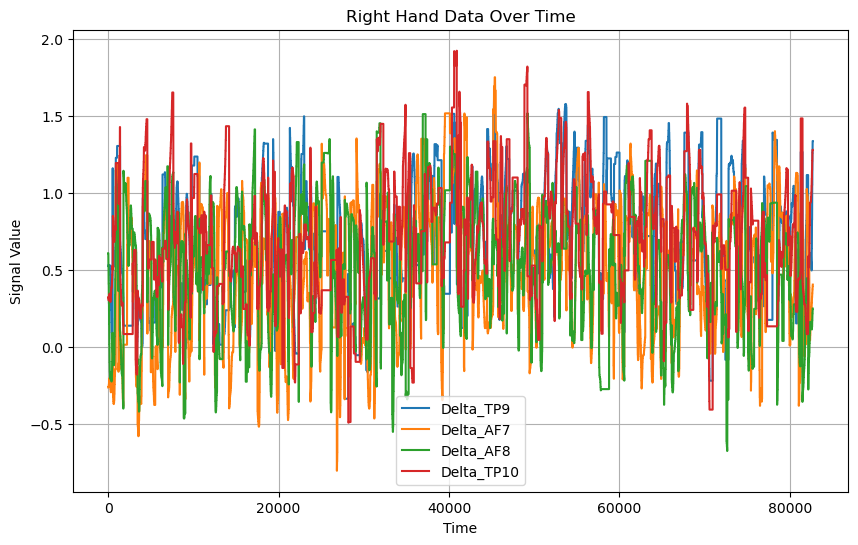

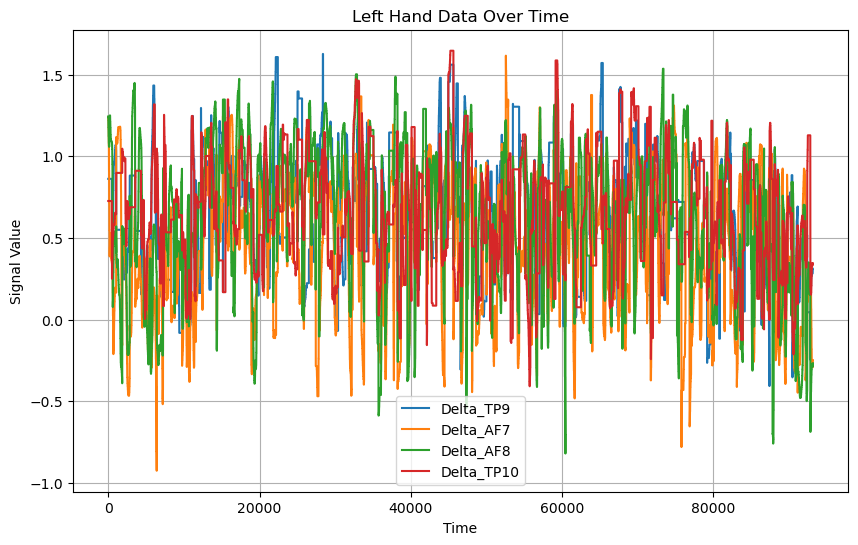

In [8]:
'''
This code cell visualises the data by plotting the Delta, Theta, Alpha, Beta, and Gamma waves for each body part.
'''
import matplotlib.pyplot as plt

# Define a function to plot body part data
def plot_body_part(body_part_data, body_part_name, columns):
    # Plot each column for the body part
    plt.figure(figsize=(10, 6))
    for col in columns:
        plt.plot(body_part_data.index, body_part_data[col], label=col)
    
    # Add title and labels
    plt.title(f'{body_part_name} Data Over Time')
    plt.xlabel('Time')
    plt.ylabel('Signal Value')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot right hand data
plot_body_part(right_hand, 'Right Hand', columns)

# Plot left hand data
plot_body_part(left_hand, 'Left Hand', columns)

# Plot right leg data
# plot_body_part(right_leg, 'Right Leg', columns)

# # Plot left leg data
# plot_body_part(left_leg, 'Left Leg', columns)



In [15]:
import pandas as pd
import numpy as np
from pyspark.sql import functions as F
from datetime import timedelta

def create_dataset(start_time, end_time, cols, granularity=1000):
    timestamps = pd.date_range(start_time, end_time, freq=str(granularity)+'ms')
    data_table = spark.createDataFrame(index=timestamps, columns=cols)
    for col in cols:
        data_table[str(col)] = np.nan #initialize the columns
    return data_table

def num_sampling(dataset, data_table, value_cols, aggregation='avg', granularity=1000):
        relevant_rows = dataset[
            (dataset['TimeStamp'] >= data_table.select("TimeStamp").head(1)[0][0]) &
            (dataset['TimeStamp'] < (data_table.select("TimeStamp").head(1)[0][0] +
                                    timedelta(milliseconds=1000)))] 
        for col in value_cols:
            # numerical cols which for the EEG data are the brain waves
            # We take the average value
            if len(relevant_rows) > 0:
                data_table.loc[data_table.index[i], str(col)] = np.average(relevant_rows[col])
            else:
                data_table.loc[data_table.index[i], str(col)] = np.nan 
        return data_table

file_path = r'C:\Users\sachi\pyspark_tutorial\muse_pipeline\Telepathic-Navigation\muse_dataset\Trial_1\Right_hand\museMonitor_2024-09-29--18-14-34_3009748603187156204.csv'

dataset = spark.read.csv(file_path, header=True, inferSchema=True)

from pyspark.sql.window import Window
window_spec = Window.orderBy('TimeStamp').rangeBetween(0, 1000)
agg_exprs = []
for col in columns_to_analyze:
    agg_exprs.append(F.avg(col).over(window_spec).alias(col))

agg_exprs

[Column<'avg(TimeStamp) OVER (ORDER BY TimeStamp ASC NULLS FIRST RANGE BETWEEN CURRENT ROW AND 1000 FOLLOWING) AS TimeStamp'>,
 Column<'avg(Delta_TP9) OVER (ORDER BY TimeStamp ASC NULLS FIRST RANGE BETWEEN CURRENT ROW AND 1000 FOLLOWING) AS Delta_TP9'>,
 Column<'avg(Delta_AF7) OVER (ORDER BY TimeStamp ASC NULLS FIRST RANGE BETWEEN CURRENT ROW AND 1000 FOLLOWING) AS Delta_AF7'>,
 Column<'avg(Delta_AF8) OVER (ORDER BY TimeStamp ASC NULLS FIRST RANGE BETWEEN CURRENT ROW AND 1000 FOLLOWING) AS Delta_AF8'>,
 Column<'avg(Delta_TP10) OVER (ORDER BY TimeStamp ASC NULLS FIRST RANGE BETWEEN CURRENT ROW AND 1000 FOLLOWING) AS Delta_TP10'>,
 Column<'avg(Theta_TP9) OVER (ORDER BY TimeStamp ASC NULLS FIRST RANGE BETWEEN CURRENT ROW AND 1000 FOLLOWING) AS Theta_TP9'>,
 Column<'avg(Theta_AF7) OVER (ORDER BY TimeStamp ASC NULLS FIRST RANGE BETWEEN CURRENT ROW AND 1000 FOLLOWING) AS Theta_AF7'>,
 Column<'avg(Theta_AF8) OVER (ORDER BY TimeStamp ASC NULLS FIRST RANGE BETWEEN CURRENT ROW AND 1000 FOLLOWING